In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns


pd.options.mode.chained_assignment = None
%matplotlib inline


In [3]:
def read_data(data = 'data_name')->pd.DataFrame:
    df = pd.read_csv(data, delimiter = ';', low_memory = False)
    df['date'] = pd.to_datetime(df['date'], format='%y%m%d')
    return df

def filter_features(ls = [], df = pd.DataFrame)->pd.DataFrame:
    features = ['date', 'account_id', 'type', 'amount']
    
    df = df[['date', 'account_id', 'type', 'amount']]
    to_replace = {'PRIJEM': 'CREDIT', 'VYDAJ': 'WITHDRAWAL', 'VYBER': 'NOT SURE', 'DEBIT': 'WITHDRAWAL','Debit':'WITHDRAWAL','account-id':'account_id'}
    df['type'] = df['type'].replace(to_replace)
    if 'date' in ls:
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df = df[df['type'] == 'WITHDRAWAL']
    df.sort_values(by = 'account_id')
    df.set_index('date',inplace = True)
    df['sum_5days'] = df.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=5)).sum())
    df['count_5days'] = df.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=5)).count())
    return df
def visualize_anomaly_detection(df_withdrawals, clf):
    clf_name = 'Anomaly Detection-Isolation Forest'
    """
    Visualize the results of anomaly detection using Isolation Forest.

    Args:
    df_withdrawals (DataFrame): DataFrame containing withdrawal transaction data.
    clf: Isolation Forest model trained for anomaly detection.
    clf_name (str): Name of the Isolation Forest model.

    Returns:
    None
    """
    xx , yy = np.meshgrid(np.linspace(0, 11, 200), np.linspace(0, 180000, 200))

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    threshold = (df_withdrawals.loc[df_withdrawals['y_pred'] == 1, 'y_scores'].min() * -1) / 2 + \
                (df_withdrawals.loc[df_withdrawals['y_pred'] == 0, 'y_scores'].max() * -1) / 2

    subplot = plt.subplot(1, 1, 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 10), cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')

    msk = df_withdrawals['y_pred'] == 0
    x = df_withdrawals.loc[msk, ['count_5days', 'sum_5days']].values

    # scatter plot of inliers with white dots
    b = subplot.scatter(x[:, 0], x[:, 1], c='white', s=20, edgecolor='k')

    msk = df_withdrawals['y_pred'] == 1
    x = df_withdrawals.loc[msk, ['count_5days', 'sum_5days']].values

    # scatter plot of outliers with black dots
    c = subplot.scatter(x[:, 0], x[:, 1], c='black', s=20, edgecolor='r')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'inliers', 'outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='upper right')

    subplot.set_title(clf_name)
    subplot.set_xlim((0, 11))
    subplot.set_ylim((0, 180000))

    subplot.set_xlabel("5-day count of withdrawal transactions.")
    subplot.set_ylabel("5-day sum of withdrawal transactions")

    plt.show()




In [4]:
from joblib import load
clf = load('clf.joblib')


In [5]:
clf_name = "Anomaly Detection"

In [6]:
df = read_data("D:/Hack-O-Hire/data/trans.csv")

In [7]:
df_new = filter_features(ls = df.columns,df =df)

In [8]:
df_new

,account_id,type,amount,sum_5days,count_5days
date,,,,,
1993-01-31,2378,WITHDRAWAL,34700.0,34700.0,1.0
1993-02-03,485,WITHDRAWAL,25300.0,25300.0,1.0
1993-02-06,3510,WITHDRAWAL,1600.0,1600.0,1.0
1993-02-07,2378,WITHDRAWAL,9612.0,9612.0,1.0
1993-02-07,2122,WITHDRAWAL,14100.0,14100.0,1.0
...,...,...,...,...,...
1998-12-31,2346,WITHDRAWAL,14.9,14.9,1.0
1998-12-31,5066,WITHDRAWAL,3.5,3.5,1.0
1998-12-31,7520,WITHDRAWAL,67.2,197.4,2.0


In [9]:
import joblib

# Load the Isolation Forest model from the joblib file
loaded_model = joblib.load('clf.joblib')

# Assuming you have new data stored in a DataFrame called 'new_data'
# Extract the relevant features from the new data
X_new = df_new[['count_5days', 'sum_5days']]

# Get the predictions and anomaly scores for the new data
y_pred_new = loaded_model.predict(X_new)
y_scores_new = loaded_model.decision_function(X_new)

# Now you can use y_pred_new and y_scores_new for further analysis or visualization
df_new['y_pred'] = y_pred_new
df_new['y_scores'] = y_scores_new

c:\Users\yashv\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
c:\Users\yashv\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


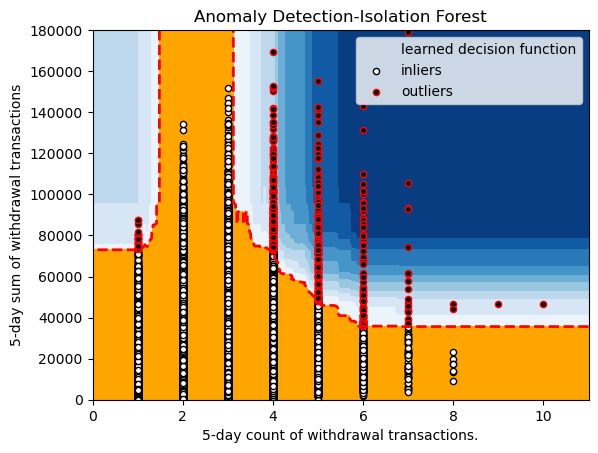

In [10]:
visualize_anomaly_detection(df_new, clf)

In [11]:
df = pd.read_csv("D:/Hack-O-Hire/data/mystatements.csv")

In [12]:
df

,Txn Date,Date,account-id,Debit,Credit
0,01-Feb-24,2024-02-01,TRANSFER FROM 4897735162098,,33
1,01-Feb-24,2024-02-01,TRANSFER TO 4897693162093,66,
2,01-Feb-24,2024-02-01,TRANSFER TO 4897693162093,25,
3,01-Feb-24,2024-02-01,TRANSFER TO 4897693162093,130,
4,01-Feb-24,2024-02-01,TRANSFER TO 4897693162093,26,
...,...,...,...,...,...
157,29-Feb-24,2024-02-29,TRANSFER TO 4897693162093,500,
158,29-Feb-24,2024-02-29,TRANSFER TO 4897693162093,"1,300.00",
159,29-Feb-24,2024-02-29,TRANSFER TO 4897693162093,137.5,
160,NaN,NaN,NaN,NaN,NaN


In [13]:
def filter_bank_data(df = pd.DataFrame)->pd.DataFrame:
        df.dropna(subset = ['Debit'], inplace = True)
        df = df[df['Debit'] != ' ']
        df = df.assign(type='Debit')
        df.rename(columns={'Debit': 'amount'}, inplace=True)
        df['amount'] = df['amount'].replace(',', '', regex=True).astype(float)
        df.drop(columns = ['Txn Date'],inplace = True)
        df['account-id'] = df['account-id'].apply(lambda s: int(s.split()[2]))
        df.drop(columns = ['Credit'], inplace = True)
        df.rename(columns={'Date': 'date', 'account-id':'account_id'}, inplace=True)
        df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
        df.set_index('date',inplace = True)
        df['sum_5days'] = df.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=5)).sum())
        df['count_5days'] = df.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=5)).count())
        df_new = df
        return df_new

    

In [14]:
df_new= filter_bank_data(df = df)

In [15]:
df

,Txn Date,Date,account-id,Debit,Credit
0,01-Feb-24,2024-02-01,TRANSFER FROM 4897735162098,,33
1,01-Feb-24,2024-02-01,TRANSFER TO 4897693162093,66,
2,01-Feb-24,2024-02-01,TRANSFER TO 4897693162093,25,
3,01-Feb-24,2024-02-01,TRANSFER TO 4897693162093,130,
4,01-Feb-24,2024-02-01,TRANSFER TO 4897693162093,26,
...,...,...,...,...,...
155,29-Feb-24,2024-02-29,TRANSFER FROM 4897735162098,,"10,000.00"
156,29-Feb-24,2024-02-29,TRANSFER TO 4897693162093,110,
157,29-Feb-24,2024-02-29,TRANSFER TO 4897693162093,500,
158,29-Feb-24,2024-02-29,TRANSFER TO 4897693162093,"1,300.00",


In [16]:
ls = ['home',34,5,7,3,2]

if 'home' in ls:
    print("there")

there


In [17]:
def alter_columns(df = pd.DataFrame)->pd.DataFrame:
    df.dropna(subset = ['Debit'], inplace = True)
    df = df[df['Debit'] != ' ']
    df.drop(columns = ['Txn Date'],inplace = True)
    df['account-id'] = df['account-id'].apply(lambda s: int(s.split()[2]))
    df.rename(columns={'Date': 'date', 'account-id':'account_id'}, inplace=True)
    df.rename(columns={'Debit': 'amount'}, inplace=True)
    df = df.assign(type='Debit')
    df.drop(columns = ['Credit'], inplace = True)
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
    df.set_index('date',inplace = True)
    df_new = df
    return df_new

In [18]:
df_new = alter_columns(df)

In [19]:
df_new

,account_id,amount,type
date,,,
2024-02-01,4897693162093,66,Debit
2024-02-01,4897693162093,25,Debit
2024-02-01,4897693162093,130,Debit
2024-02-01,4897693162093,26,Debit
2024-02-01,4897693162093,89,Debit
...,...,...,...
2024-02-29,4897693162093,199,Debit
2024-02-29,4897693162093,110,Debit
2024-02-29,4897693162093,500,Debit


In [20]:
def check_amount_and_sum(df = pd.DataFrame):
    df['amount'] = df['amount'].replace(',', '', regex=True).astype(float)
    df['sum_5days'] = df.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=5)).sum())
    df['count_5days'] = df.groupby('account_id')['amount'].transform(lambda s: s.rolling(timedelta(days=5)).count())

    

In [21]:
check_amount_and_sum(df_new)

In [22]:
df_new

,account_id,amount,type,sum_5days,count_5days
date,,,,,
2024-02-01,4897693162093,66.0,Debit,66.0,1.0
2024-02-01,4897693162093,25.0,Debit,91.0,2.0
2024-02-01,4897693162093,130.0,Debit,221.0,3.0
2024-02-01,4897693162093,26.0,Debit,247.0,4.0
2024-02-01,4897693162093,89.0,Debit,336.0,5.0
...,...,...,...,...,...
2024-02-29,4897693162093,199.0,Debit,438.0,3.0
2024-02-29,4897693162093,110.0,Debit,548.0,4.0
2024-02-29,4897693162093,500.0,Debit,1048.0,5.0


In [25]:
df_results = predict(df = df_new)

c:\Users\yashv\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
c:\Users\yashv\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [26]:
df_results

,account_id,amount,type,sum_5days,count_5days,y_pred,y_scores
date,,,,,,,
2024-02-01,4897693162093,66.0,Debit,66.0,1.0,0,-0.342445
2024-02-01,4897693162093,25.0,Debit,91.0,2.0,0,-0.230481
2024-02-01,4897693162093,130.0,Debit,221.0,3.0,0,-0.161682
2024-02-01,4897693162093,26.0,Debit,247.0,4.0,0,-0.089227
2024-02-01,4897693162093,89.0,Debit,336.0,5.0,0,-0.038234
...,...,...,...,...,...,...,...
2024-02-29,4897693162093,199.0,Debit,438.0,3.0,0,-0.165984
2024-02-29,4897693162093,110.0,Debit,548.0,4.0,0,-0.097363
2024-02-29,4897693162093,500.0,Debit,1048.0,5.0,0,-0.049576


In [27]:
visualize_anomalies_3d(df_results)

NameError: name 'visualize_anomalies_3d' is not defined

In [439]:
visualize_anomalies_with_date(df_results)

In [399]:
import joblib

# Load the Isolation Forest model from the joblib file
loaded_model = joblib.load('clf.joblib')

# Assuming you have new data stored in a DataFrame called 'new_data'
# Extract the relevant features from the new data
X_new = df[['count_5days', 'sum_5days']]

# Get the predictions and anomaly scores for the new data
y_pred_new = loaded_model.predict(X_new)
y_scores_new = loaded_model.decision_function(X_new)

# Now you can use y_pred_new and y_scores_new for further analysis or visualization
df['y_pred'] = y_pred_new
df['y_scores'] = y_scores_new

C:\Users\yashv\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but IsolationForest was fitted without feature names

C:\Users\yashv\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but IsolationForest was fitted without feature names



In [29]:
def predict(df = pd.DataFrame)->pd.DataFrame:
    import joblib

# Load the Isolation Forest model from the joblib file
    loaded_model = joblib.load('clf.joblib')

# Assuming you have new data stored in a DataFrame called 'new_data'
# Extract the relevant features from the new data
    X_new = df[['count_5days', 'sum_5days']]

# Get the predictions and anomaly scores for the new data
    y_pred_new = loaded_model.predict(X_new)
    y_scores_new = loaded_model.decision_function(X_new)

# Now you can use y_pred_new and y_scores_new for further analysis or visualization
    df['y_pred'] = y_pred_new
    df['y_scores'] = y_scores_new
    
    df_new =df
    
    return df_new
    
    

In [30]:
df_new = predict(df)

KeyError: "None of [Index(['count_5days', 'sum_5days'], dtype='object')] are in the [columns]"

In [409]:
df_new

,account_id,amount,type,sum_5days,count_5days,y_pred,y_scores
date,,,,,,,
2024-02-01,4897693162093,66.0,Debit,66.0,1.0,0,-0.342445
2024-02-01,4897693162093,25.0,Debit,91.0,2.0,0,-0.230481
2024-02-01,4897693162093,130.0,Debit,221.0,3.0,0,-0.161682
2024-02-01,4897693162093,26.0,Debit,247.0,4.0,0,-0.089227
2024-02-01,4897693162093,89.0,Debit,336.0,5.0,0,-0.038234
...,...,...,...,...,...,...,...
2024-02-29,4897693162093,199.0,Debit,438.0,3.0,0,-0.165984
2024-02-29,4897693162093,110.0,Debit,548.0,4.0,0,-0.097363
2024-02-29,4897693162093,500.0,Debit,1048.0,5.0,0,-0.049576


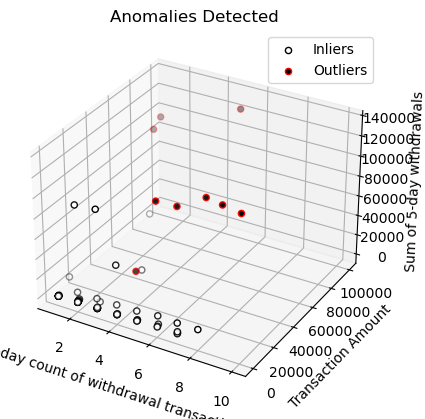

In [316]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_anomalies_3d(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract data for inliers and outliers
    inliers = df[df['y_pred'] == 0]
    outliers = df[df['y_pred'] == 1]

    # Plot inliers and outliers
    ax.scatter(inliers['count_5days'], inliers['amount'], inliers['sum_5days'], c='white', s=20, edgecolor='k', label='Inliers')
    ax.scatter(outliers['count_5days'], outliers['amount'], outliers['sum_5days'], c='black', s=20, edgecolor='r', label='Outliers')

    # Set labels and title
    ax.set_xlabel('5-day count of withdrawal transactions')
    ax.set_ylabel('Transaction Amount')
    ax.set_zlabel('Sum of 5-day withdrawals')
    ax.set_title('Anomalies Detected')

    # Show legend
    ax.legend()

    # Show plot
    plt.show()

# Call the function to visualize anomalies in 3D
visualize_anomalies_3d(df)


In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_anomalies_with_date(df):
    # Create a subplot with Plotly
    fig = make_subplots(rows=1, cols=1)

    # Plot non-anomalous data
    fig.add_trace(go.Scatter(x=df[df['y_pred'] == 0].index, 
                             y=df[df['y_pred'] == 0]['sum_5days'] / 1000, 
                             mode='markers', 
                             marker=dict(color='blue', symbol='circle'),
                             name='Non-Anomalous'), 
                  row=1, col=1)

    # Highlight anomalous data
    fig.add_trace(go.Scatter(x=df[df['y_pred'] == 1].index, 
                             y=df[df['y_pred'] == 1]['sum_5days'] / 1000, 
                             mode='markers', 
                             marker=dict(color='red', symbol='x'),
                             name='Anomalous'), 
                  row=1, col=1)

    # Set layout options
    fig.update_layout(title='Anomalies Detected Over Time',
                      xaxis_title='Date',
                      yaxis_title='Sum of 5-day withdrawals (in thousands)',
                      showlegend=True,
                      hovermode='x unified',
                      xaxis=dict(
                          range=[df.index.min(), df.index.max() + pd.DateOffset(days=5)]  # Stretching x-axis by 5 days
                      ))

    # Annotate anomalies with their exact values
    for index, row in df[df['y_pred'] == 1].iterrows():
        fig.add_annotation(x=index, y=row['sum_5days'] / 1000,
                           text=f"Anomaly\n{row['sum_5days'] / 1000:.2f}k",
                           showarrow=True,
                           arrowhead=1,
                           arrowcolor='red',
                           arrowwidth=1,
                           ax=20,
                           ay=-40,
                           font=dict(size=10, color='red'))

    # Show plot
    fig.show()

# Call the function to visualize anomalies with dates
visualize_anomalies_with_date(df)


KeyError: 'y_pred'

In [441]:
import plotly.graph_objects as go

def visualize_anomalies_3d(df):
    # Create figure
    fig = go.Figure()

    # Extract data for inliers and outliers
    inliers = df[df['y_pred'] == 0]
    outliers = df[df['y_pred'] == 1]

    # Plot inliers
    fig.add_trace(go.Scatter3d(
        x=inliers['count_5days'],
        y=inliers['amount'],
        z=inliers['sum_5days'],
        mode='markers',
        marker=dict(
            color='white',
            size=5,
            line=dict(
                color='black',
                width=0.5
            )
        ),
        name='Inliers'
    ))

    # Plot outliers
    fig.add_trace(go.Scatter3d(
        x=outliers['count_5days'],
        y=outliers['amount'],
        z=outliers['sum_5days'],
        mode='markers',
        marker=dict(
            color='black',
            size=5,
            line=dict(
                color='red',
                width=0.5
            )
        ),
        name='Outliers'
    ))

    # Update layout
    fig.update_layout(
        scene=dict(
            xaxis_title='5-day count of withdrawal transactions',
            yaxis_title='Transaction Amount',
            zaxis_title='Sum of 5-day withdrawals',
            aspectmode='cube'
        ),
        title='Anomalies Detected'
    )

    # Show plot
    fig.show()

# Call the function to visualize anomalies in 3D
visualize_anomalies_3d(df_results)
